In [1]:
import glob
import torch
import requests
import random
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from denoising_diffusion_pytorch import Trainer
import os
from torch.utils.data import Dataset
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache
from torch.utils.data import DataLoader
import math
import copy
import climpred
from pathlib import Path
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count
from torch import nn, einsum
import torch.nn.functional as F
from torch.nn import Module, ModuleList
from torch.amp import autocast
from torch.optim import Adam
from torchvision import transforms as T, utils
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA
from accelerate import Accelerator
from denoising_diffusion_pytorch.attend import Attend
from denoising_diffusion_pytorch.version import __version__
import matplotlib.pyplot as plt

In [2]:
""
gpu_id=0
""
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    
if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

config = {
        "input_channels": 1,
        "output_channels": 1,
        "context_image": True,
        "context_channels": 1,
        "num_blocks": [2, 2],
        "hidden_channels": 32,
        "hidden_context_channels": 8,
        "time_embedding_dim": 256,
        "image_size": 128,
        "noise_sampling_coeff": 0.85,
        "denoise_time": 970,
        "activation": "gelu",
        "norm": True,
        "subsample": 100000,
        "save_name": "model_weights.pt",
        "dim_mults": [4, 4],
        "base_dim": 32,
        "timesteps": 1000,
        "pading": "reflect",
        "scaling": "std",
        "optimization": {
            "epochs": 400,
            "lr": 0.01,
            "wd": 0.05,
            "batch_size": 32,
            "scheduler": True
        }
    }

model = Unet(
    channels = 1,
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True,
    self_condition = False
)


diffusion = GaussianDiffusion(
    model,
    image_size = (128, 128),
    timesteps = 1000,    # number of steps
    auto_normalize = True,
    objective = "pred_v",
)
diffusion.is_ddim_sampling = True
word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
WORDS = response.content.splitlines()

rn1 = random.randint(0, 10000)
rn2 = random.randint(0, 10000)

w1 = str(WORDS[rn1]).split('b')[1][1:-1]
w2 = str(WORDS[rn2]).split('b')[1][1:-1]

run_name = f'{w1}_{w2}'

print(f'my name is {run_name}')
trainer = Trainer(
    diffusion,
    '/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_0/',
    run_name,
    do_wandb = True,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 10000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False,           # whether to calculate fid during training
    max_grad_norm = 1.0,
)


models = sorted([I for I in glob.glob('/glade/work/timothyh/Diffusion/Forecasting/denoising-diffusion-pytorch/results/*.pt')])
trainer.load(str(len(models)))

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
2
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda
my name is levitra_anthony


/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(
/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/accelerate/accelerator.py:469: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/glade/work/timothyh/Diffusion/Forecasting/denoising-diffusion-pytorch/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py:1168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct 

loading from version 2.0.17


In [3]:
mean = 152.16729736328125
std = 147.735107421875
maxivt = 15.220598
minivt = -1.0300009
dataX = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_120/test.nc').forecast
datay = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_120/test.nc').analysis
dataX = (dataX-mean)/std
dataX = (dataX-minivt)/(maxivt-minivt)
datay = (datay-mean)/std
datay = (datay-minivt)/(maxivt-minivt)
X = torch.tensor(dataX.values).to(device).unsqueeze(1)
sampled_images = diffusion.sample(X, batch_size = 117, return_all_timesteps = False)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/contextlib.py:83: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


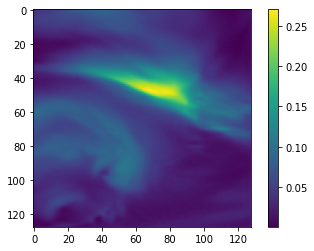

In [4]:
denoised = sampled_images.detach().cpu().numpy()
image_num=1
plt.imshow(denoised[image_num,0,:,:])
plt.colorbar()

In [5]:
X = np.array(dataX)
Y = np.array(datay)
denoised = np.squeeze(denoised)


In [6]:
acc = climpred.metrics._pearson_r(xr.DataArray(X[:]),xr.DataArray(Y[:]),dim=["dim_0"])
accdiffusion = climpred.metrics._pearson_r(xr.DataArray(denoised[:]),xr.DataArray(Y[:]),dim=["dim_0"])

In [7]:
np.mean(acc)

<xarray.DataArray ()>
array(0.56538169)

In [8]:
np.mean(accdiffusion)

<xarray.DataArray ()>
array(0.56970642)